[EDA TODO:](https://docs.google.com/document/d/1N711UXfrLI09kV_NdWNkG6TK677rAHMHuH_gMttfxRs/edit)
- MOST COMMON TERMS
   - overall
   - By brand
   - By Contact type (HCP vs Patient) – assuming CONTACT_TYPE US Consumer = HCP
   - IVR Reason
   - By call type – transfer vs regular
   - By call duration (short, long calls – what are they about?)
- MOST COMMON MEDICAL TERMS
   - overall
   - By brand
   - By Contact type (HCP vs Patient) – assuming CONTACT_TYPE US Consumer = HCP
   - IVR Reason
   - By call type – transfer vs regular
   - By call duration (short, long calls – what are they about?)
- SENTIMENT
   - overall
   - By brand
   - By Contact type (HCP vs Patient) – assuming CONTACT_TYPE US Consumer = HCP
   - IVR Reason
   - By call type – transfer vs regular
   - By call duration (short, long calls – what are they about?)

In [117]:
import pandas as pd
import numpy as np

df = {'ts_md': pd.read_csv('df/ts_md.csv', index_col = 0, parse_dates = ['CREATED_DATE_TIME']),
      'md_ent': pd.read_csv('df/md_ent.csv', index_col = 0),
      'ts_ent': pd.read_csv('df/ts_ent.csv', index_col = 0),
      'ts_sent': pd.read_csv('df/ts_sent.csv', index_col = 0),
      'rep_sent': pd.read_csv('df/rep_sent.csv', index_col = 0),
      'cus_sent': pd.read_csv('df/cus_sent.csv', index_col = 0),
     }

def get_sent_type(mag, score):
    '''
     Create sentiment categories. n.b. pd.qcut vs. pd.cut below!
    '''
    sent_type = {'l-': 'maybe negative', 'ln': 'neutral', 'l+': 'maybe positive',
                 'm-': 'negative', 'mn': 'mixed', 'm+': 'positive',
                 'h-': 'very negative', 'hn': 'very mixed', 'h+': 'very positive'}
    return [sent_type[x] for x in pd.qcut(mag, 3, labels = ['l', 'm', 'h']).astype(str) + 
                                  pd.cut(score, [-1, -0.1, 0.1, 1], labels = ['-', 'n', '+']).astype(str)]

df['ts_sent']['sent_type'] = get_sent_type(df['ts_sent']['magnitude'], df['ts_sent']['score'])

Documentation
- Entity: https://cloud.google.com/natural-language/docs/reference/rest/v1/Entity#Type
- Sentiment: https://cloud.google.com/natural-language/docs/basics#interpreting_sentiment_analysis_values

# 7/8/2022

In [3]:
df['ts_md']['IVR_REASON'].nunique()

94

<AxesSubplot:>

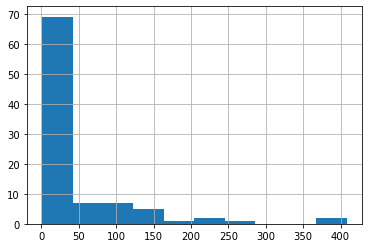

In [4]:
df['ts_md']['IVR_REASON'].value_counts().hist()

In [5]:
df['ts_sent']['score'].describe()

count    4127.000000
mean        0.049624
std         0.102225
min        -0.700000
25%         0.000000
50%         0.000000
75%         0.100000
max         0.800000
Name: score, dtype: float64

<AxesSubplot:xlabel='score', ylabel='magnitude'>

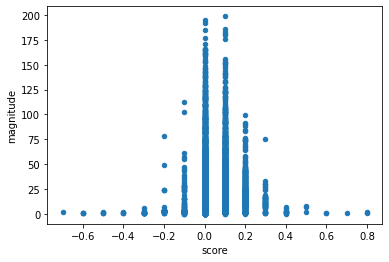

In [6]:
df['ts_sent'].plot.scatter('score', 'magnitude')

| Score, Magnitude:  | Low  | Medium | High |
|---|---|---|---|
| Negative | Maybe negative | Negative | Very negative |
| Zero | Neutral | Mixed | Very mixed |
| Positive | Maybe positive | Positive | Very positive |

| Score, Magnitude:  | Low  | Medium | High | Total |
|---|---|---|---|---|
| Negative | 262 (maybe negative) | 20 (negative) | 14 (very negative) | **296** | 
| Zero | 908 (neutral) | 1176 (mixed) | 1267 (very mixed) | **3351** | 
| Positive | 216 (maybe positive) | 170 (positive) | 94 (very positive) | **480** | 
| **Total** | **1386** | **1375** | **1366** | **4127** | 

In [ ]:
# mark Q: months and 
# wordcloud for negative sentiment calls (so we can correlate it to https://docs.google.com/presentation/d/1gWxoouBanQOkFCfNGvZBFyooH2XEkwsZDp3eXznamKI/)
# align this with deck (do it by word clouds, topic analysis, extracting '$' entity etc.)

# sentiment between categories (slide 7):
#    https://docs.google.com/presentation/d/1gWxoouBanQOkFCfNGvZBFyooH2XEkwsZDp3eXznamKI/edit#slide=id.gf4f734b47b_0_19
# emotional response: "here's what your customers are upset about," "here's what they are happy about :)"


In [11]:
for sent_type_ in ['very negative']:
    call_ids = df['ts_sent'][(df['ts_sent']['sent_type'] == sent_type_)].index
    print(f'\n{sent_type_}:')
    print(df['ts_md'].loc[df['ts_md'].index.isin(call_ids), 'transcript'].values)


very negative:
[". Thank you for calling the response center . My name is shinter . How may I assist you today ?. All right .  I am trying to reach , uh , the executive assistant of em a long sleeve . Can you please connect me.  Um , and , sir , unfortunately , I won't be able to do that , because I can't place , uh , transpontin and then I'll call.  Oh , but she said not in the United States.  I don't believe so , no , sir ..  Okay . Who's the most seeing your person that , uh , that , uh , takes , uh , a feedback from your customers.  How have they listed ?.  ..  So , , I , I don't have senior level names in my directory that , that they're not listed that way , sir , but every feedback that we get from a customer , every feedback that we get from a customer , we knowtate it on the account , and it goes to a corporate office .  Okay .  But I don't have a name of who it goes to . . .  No , no , no , no , no , no .  No . There's got to be , there's got to be a customer relations offic

# 7/12/2022

distance: $\mathbf {A} \cdot \mathbf {B} =\left\|\mathbf {A} \right\|\left\|\mathbf {B} \right\|\cos \theta.$


    

# 7/13/2022

In [ ]:
# TODO
# finish encoding the vectors (DONE)
# do corr plot of all numeric vectors against each other (DONE)

In [49]:
dist = df['ts_md'][['call_len_sec', 'CREATED_DATE_TIME', 
                    'IVR_REASON', 'INCONTACT_SKILL', 'PRODUCT_NAME', 
                    'CASE_TIER_1_GLOBAL', 'CASE_TIER_2_US', 'CASE_TIER_3_US',
                    'transcript', 'md_desc']].copy()

dist['call_len_sec'] = dist['call_len_sec'].astype(int)
dist['call_day']  = dist['CREATED_DATE_TIME'].dt.weekday
dist['call_hour'] = dist['CREATED_DATE_TIME'].dt.hour

# Get inverse frequency score from categorical columns
dist_dict = {}
for col in ['IVR_REASON', 'INCONTACT_SKILL', 'PRODUCT_NAME', 'CASE_TIER_1_GLOBAL', 'CASE_TIER_2_US', 'CASE_TIER_3_US', 'call_day', 'call_hour']:
    dist_dict[col] = (1 / dist[col].value_counts(normalize = True)).to_dict()
    dist_dict[col][np.nan] = np.nan
    dist[col] = [dist_dict[col][val] for val in dist[col]]
# Drop
dist.drop(columns = ['CREATED_DATE_TIME', 'transcript', 'md_desc'], inplace = True)
# dist.drop(columns = ['call_day', 'call_hour'], inplace = True)
dist = dist.astype(float)
# Impute np.nan with mean
dist = dist.fillna(dist.mean().to_dict())
# Normalize
dist = (dist - dist.mean()) / dist.std()
# Calculate `dist`
dist['dist'] = np.linalg.norm(dist, axis = 1)
# Make labels
dist['Length of call'] = pd.cut(dist['call_len_sec'], 
                             [dist['call_len_sec'].min(), 
                              dist['call_len_sec'].mean(), 
                              dist['call_len_sec'].max()], labels = ['Short', 'Long'])
dist['Call type'] = pd.cut(dist['dist'],
                           [dist['dist'].min(), 
                            dist['dist'].mean(), 
                            dist['dist'].max()], labels = ['Normal', 'Atypical'])
# Merge back
df['ts_md']['Length of call'] = dist['Length of call']
df['ts_md']['Call type'] = dist['Call type']
# Create `ts_md_pretty`
ts_md_pretty = df['ts_md'][['call_len_sec', 'CREATED_DATE_TIME', 
                    'IVR_REASON', 'INCONTACT_SKILL', 'PRODUCT_NAME', 
                    'CASE_TIER_1_GLOBAL', 'CASE_TIER_2_US', 'CASE_TIER_3_US', 
                    'SUBJECT', 'transcript', 'md_desc', 'Length of call', 'Call type']].copy()
ts_md_pretty['Length of call'] = dist['Length of call']
ts_md_pretty['Call type'] = dist['Call type']

pd.crosstab(dist['Call type'], dist['Length of call'], 
            margins = True, margins_name = 'Sum', normalize = True).round(4) * 100

# Export
ts_md_pretty.to_csv('df/ts_md_pretty.csv')
dist.to_csv('df/dist.csv')

# Calculate length of sample
time_range_min = (df['ts_md']['CREATED_DATE_TIME'].max() - df['ts_md']['CREATED_DATE_TIME'].min()) \
                 .total_seconds() / 60
# Calculate Total call volume
total_time_min = df['ts_md']['call_len_sec'].sum() / 60

In [138]:
pd.crosstab(df['ts_md']['Call type'],
            df['ts_md']['Length of call'], 
            df['ts_md']['call_len_sec'], aggfunc = sum,
            margins = True, margins_name = 'Sum', normalize = True).round(4) * 100

Length of call,Short,Long,Sum
Call type,,,
Normal,30.07,31.24,61.31
Atypical,3.22,35.47,38.69
Sum,33.29,66.71,100.00


In [139]:
pd.crosstab(df['ts_md']['Call type'],
            df['ts_md']['Length of call'], 
            df['ts_md']['call_len_sec'], aggfunc = sum,
            margins = True, margins_name = 'Sum') / 60 / 60 / 24

Length of call,Short,Long,Sum
Call type,,,
Normal,7.334722,7.619444,14.954167
Atypical,0.785069,8.650000,9.435069
Sum,8.119792,16.269444,24.389236


In [140]:
dist.corr()

,call_len_sec,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,call_day,call_hour,dist
call_len_sec,1.000000,-0.038371,0.019021,0.056147,0.075376,0.073285,0.052337,0.032453,0.045210,0.218253
IVR_REASON,-0.038371,1.000000,0.270207,0.016404,-0.003192,0.051855,0.039893,0.029411,0.009101,0.430838
INCONTACT_SKILL,0.019021,0.270207,1.000000,0.023441,0.016046,0.057648,0.070610,0.019048,-0.005665,0.434914
PRODUCT_NAME,0.056147,0.016404,0.023441,1.000000,0.125556,0.072024,0.013339,-0.009852,0.012191,0.394963
CASE_TIER_1_GLOBAL,0.075376,-0.003192,0.016046,0.125556,1.000000,0.366174,0.027361,-0.012561,-0.000882,0.448545
CASE_TIER_2_US,0.073285,0.051855,0.057648,0.072024,0.366174,1.000000,0.285265,0.012332,0.072569,0.535762
CASE_TIER_3_US,0.052337,0.039893,0.070610,0.013339,0.027361,0.285265,1.000000,-0.001734,0.030048,0.413843
call_day,0.032453,0.029411,0.019048,-0.009852,-0.012561,0.012332,-0.001734,1.000000,0.006032,-0.015168
call_hour,0.045210,0.009101,-0.005665,0.012191,-0.000882,0.072569,0.030048,0.006032,1.000000,0.360748
dist,0.218253,0.430838,0.434914,0.394963,0.448545,0.535762,0.413843,-0.015168,0.360748,1.000000


In [141]:
cost_vars = ['Length of call', 'Call type']
with pd.option_context(
                       'display.max_rows', None, 
                       'display.max_columns', None, 
#                        'display.max_colwidth', None
                      ):
    for category, group in df['ts_md'].groupby(cost_vars):
        print(category)
        _call_ids = group.sample().index
        for _call_id in _call_ids:
            _call_id = [_call_id]
            display(dist.loc[_call_id])
            display(ts_md_pretty.loc[_call_id])
            display(ts_md_pretty.loc[_call_id]['md_desc'].values)
            display(ts_md_pretty.loc[_call_id]['transcript'].values)

('Short', 'Normal')


,call_len_sec,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,call_day,call_hour,dist,Length of call,Call type
call_id,,,,,,,,,,,,
199886501750,-0.376546,-0.206794,-0.127359,-0.371262,-0.158745,-0.238371,-0.344573,0.562588,-0.041472,0.926058,Short,Normal


,call_len_sec,CREATED_DATE_TIME,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,SUBJECT,transcript,md_desc,Length of call,Call type
call_id,,,,,,,,,,,,,
199886501750,330,2022-05-12 16:13:59,Coupon Max Errors,SK_GRC_Patient_Assist_Voice,TRELEGY,General Enquiry,GRC Transfer,GRC Product Team,Product Team,Good afternoon . Thank you for calling the res...,Product Team. Caller request assistance with T...,Short,Normal


array(['Product Team. Caller request assistance with Trelegy inhaler.'],
      dtype=object)

array(["Good afternoon . Thank you for calling the responsibility . My name is oddly . How may I assist you ? .  Nope .  Okay . ..  . . If surgery , my name is slender well born . I'm calling from Plaquenex , and I'm on , my doctor has me on Dilaudid , Ellipta , and , uh , the last one that I got , I get one that for 30 days , and the last one that I got towards the end , it seemed like there wasn't any thing coming out , you know , there's , that residue in your mouth , you have to rinse your mouth . Well , this one , I've only had it eight days , and it's , it's gone to the red . It's , it's already out , , and , and I , I don't know , you know , if there's a , a problem with the , uh , uh , well , there , there's got to be a problem with the , with the , uh , container , you know , the , the dispenser. .  All right , ma'am , I'll be happy to assist you . You said your name is Namenda , Namenda , would you spell your last name for me ? . .  . Yes , my first name is spelled with a Y .

('Short', 'Atypical')


,call_len_sec,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,call_day,call_hour,dist,Length of call,Call type
call_id,,,,,,,,,,,,
200240112029,-0.18903,-0.213671,0.001953,0.04596,0.264795,2.811441,6.443688,1.026279,0.737003,7.153696,Short,Atypical


,call_len_sec,CREATED_DATE_TIME,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,SUBJECT,transcript,md_desc,Length of call,Call type
call_id,,,,,,,,,,,,,
200240112029,420,2022-05-20 17:13:20,Benlysta Promotional LASH Transfer,SK_GRC_Hub_Benlysta_Voice,BENLYSTA SC AI,Commercial Activities,GRC - Video Training,GRC Video Training Performed,Benlysta WebEx Training Performed,Thank you for calling Benlysta Cares . My name...,Benlysta WebEx Training Performed. Benlysta We...,Short,Atypical


array(['Benlysta WebEx Training Performed. Benlysta WebEx Training Performed'],
      dtype=object)

array(["Thank you for calling Benlysta Cares . My name is Rounda . I'm a registered nurse . How may I help you today ?. Um , I'm sorry ..  Yes , this has been listed here . How can I help you ?.  Um-hum.  . Yeah. .  I miss that because I was .  Yes , um , I would provide this number by , um , the CVS specialty pharmacy , because they had indicated that , um , a nurse would be available to provide some training on administering the injection . I've never administered , um , , administered an injection before , and , um , I did get you samples , and I did not do with the right way . So they're both products were wasted ..  Okay . Um , we can definitely provide some.  Is there a service that's provided ?.  Okay.  ..  Yes , we can provide virtual training for you . Um , it's set up , be a video chat . Would you like to do that now , or schedule it for sometime , or we can , we can do it now ? It's up to you ..  Okay ..  Oh , no , I don't know . Um , so , is there any video ? It's not impor

('Long', 'Normal')


,call_len_sec,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,call_day,call_hour,dist,Length of call,Call type
call_id,,,,,,,,,,,,
199956162969,1.436107,-0.234536,-0.04073,-0.371262,0.0934,-0.029196,-0.299808,1.026279,-0.041472,1.84698,Long,Normal


,call_len_sec,CREATED_DATE_TIME,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,SUBJECT,transcript,md_desc,Length of call,Call type
call_id,,,,,,,,,,,,,
199956162969,1200,2022-05-13 16:20:44,Quality Complaint,SK_GRC_Quality_Complaint_Voice,TRELEGY,Product Quality Complaints,PQC completed,Replaced by SC,Trelegy Ellipta PQC w/ Related AE,Thank you for calling the responsibility . My ...,Trelegy Ellipta PQC w/ Related AE. PQC filed. ...,Long,Normal


array(['Trelegy Ellipta PQC w/ Related AE. PQC filed. CC#201209576'],
      dtype=object)

array(['Thank you for calling the responsibility . My name is methylmalonal pharmacist . I\'m going to help you today .. Um-hum .  Uh , yeah , so I\'m calling , um , my , uh , on behalf of my mom , um , who has a trology prescription that she picked up , and , um , it doesn\'t appear to be working.  Okay ..  Okay , um , I can help you with that issue today . Um , before we start May I collect your contact information to document our call.  Absolutely . Yes ..  Uh , measured , measured first and last time , please ..  My first name is [##redacted##][##redacted##][##redacted##].  .  Um-hum ..  Last name is [##redacted##] M A G E.  All right . Thank you . And may have your phone number , please . ..  Sure , it\'s 5\'16 , 6\'8 , 0 , 5\'3 , 09.  All right , it\'s , uh , 5\'1" . 6\'6 , 6\'8 , zero , 5\'3 , 09 ..  Correct ..  Okay . And last , you may have an address , please ..  Um , my , uh , I\'m , uh , I\'m calling on behalf of my mom . Should I give you her address or my address ?.  Um ,

('Long', 'Atypical')


,call_len_sec,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,call_day,call_hour,dist,Length of call,Call type
call_id,,,,,,,,,,,,
200169259326,4.686381,-0.227273,-0.044664,0.013909,0.610812,-0.038409,-0.231317,0.562588,-0.153658,4.77328,Long,Atypical


,call_len_sec,CREATED_DATE_TIME,IVR_REASON,INCONTACT_SKILL,PRODUCT_NAME,CASE_TIER_1_GLOBAL,CASE_TIER_2_US,CASE_TIER_3_US,SUBJECT,transcript,md_desc,Length of call,Call type
call_id,,,,,,,,,,,,,
200169259326,2760,2022-05-19 13:16:09,Nucala Inbound Call,SK_GRC_Hub_Nucala_Voice,NUCALA AI,Adverse Event,AE Initial,Symptomatic,Nucala AE,". Thank you for calling and calling us , borde...",Nucala AE. Filed AE,Long,Atypical


array(['Nucala AE. Filed AE'], dtype=object)

array([". Thank you for calling and calling us , borderline my name is gel pen . I am a pharmacist talking to help you today .. . High dose , and my name is Kia , and , um , I needed to speak to someone regarding the column . I just received . Um , I wanted to wait a week , and it's been a week , and , um , I have some questions . .  Did I lose you ? Oh.  All right . So , I see that she has some questions for medication in color . Is that correct ?.  Um-hum .  Yes ..  .  Okay . I'll be happy to assist you with that . May I just start by getting your first and last name , please ?.  First name is kayaking I AH.  Last name is Namenda , AM , AM , D E. .  Thank you . May I have a zip code and a phone number for you , please ?.  Zithromax 211.7.  Phone number , HIV.  Six , six , six , three , one , one , five , one.  All right , thank you for this information and how can I help you in regards to the medication in color today. .  Um , I got the pneumococcal auto-injector , and I had that inj

# 7/21/2022 — Sentiment

In [50]:
full_df = ts_md_pretty.join(df['rep_sent'].drop(columns = ['sentences']), how = 'inner') \
                      .join(df['cus_sent'].drop(columns = ['sentences']), how = 'inner',  
                            lsuffix = '_rep', rsuffix = '_cus')

full_df['cus_sent_type'] = get_sent_type(full_df['magnitude_cus'], full_df['score_cus'])
full_df['rep_sent_type'] = get_sent_type(full_df['magnitude_rep'], full_df['score_rep'])

full_df.to_csv('df/full_df.csv')

In [159]:
pd.crosstab(df['ts_md']['Call type'],
            df['ts_md']['Length of call'], 
            df['ts_md']['call_len_sec'], aggfunc = sum,
            margins = True, margins_name = 'Sum') / 60 / 60

Length of call,Short,Long,Sum
Call type,,,
Normal,176.033333,182.866667,358.900000
Atypical,18.841667,207.600000,226.441667
Sum,194.875000,390.466667,585.341667


In [10]:
pd.crosstab(df['ts_md']['Call type'],
            df['ts_md']['Length of call'], 
            df['ts_md']['call_len_sec'], aggfunc = sum,
            margins = True, margins_name = 'Sum', normalize = True).round(4) * 100

Length of call,Short,Long,Sum
Call type,,,
Normal,30.07,31.24,61.31
Atypical,3.22,35.47,38.69
Sum,33.29,66.71,100.00


In [99]:
full_df.groupby(cost_vars).size() / full_df.shape[0]

Length of call  Call type
Short           Normal       0.613219
                Atypical     0.061825
Long            Normal       0.198040
                Atypical     0.123398
dtype: float64

In [100]:
full_df.groupby(cost_vars)['cus_sent_type'].value_counts(normalize = True)

Length of call  Call type  cus_sent_type 
Short           Normal     very mixed        0.281148
                           mixed             0.252459
                           neutral           0.234426
                           maybe positive    0.066803
                           positive          0.050410
                           maybe negative    0.036885
                           very positive     0.034016
                           very negative     0.022131
                           negative          0.021721
                Atypical   very mixed        0.296748
                           mixed             0.223577
                           neutral           0.203252
                           positive          0.085366
                           maybe positive    0.077236
                           maybe negative    0.048780
                           very positive     0.040650
                           negative          0.024390
Long            Normal     mixed        

In [60]:
full_df['score_diff'] = full_df['score_rep'] - full_df['score_cus']

<AxesSubplot:>

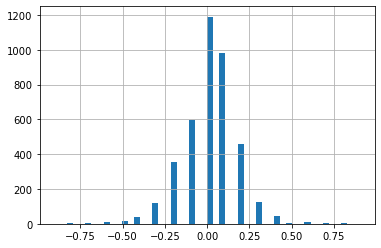

In [94]:
full_df['score_diff'].hist(bins = 50)

In [63]:
full_df.groupby(cost_vars)['score_diff'].mean()

Length of call  Call type
Short           Normal       0.015820
                Atypical     0.008130
Long            Normal       0.011802
                Atypical     0.015275
Name: score_diff, dtype: float64

In [70]:
full_df.groupby(cost_vars)['score_cus'].mean()

Length of call  Call type
Short           Normal       0.050902
                Atypical     0.060976
Long            Normal       0.050000
                Atypical     0.052138
Name: score_cus, dtype: float64

<AxesSubplot:xlabel='score_rep', ylabel='score_cus'>

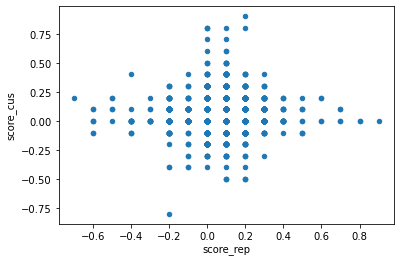

In [52]:
full_df.plot.scatter('score_rep', 'score_cus')

Length of call  Call type
Short           Normal       AxesSubplot(0.125,0.125;0.775x0.755)
                Atypical     AxesSubplot(0.125,0.125;0.775x0.755)
Long            Normal       AxesSubplot(0.125,0.125;0.775x0.755)
                Atypical     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

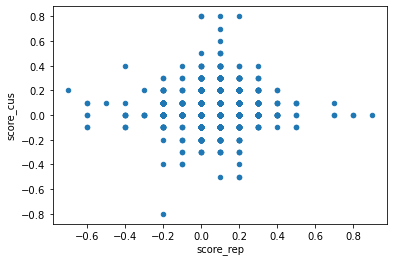

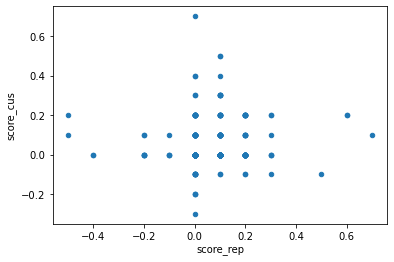

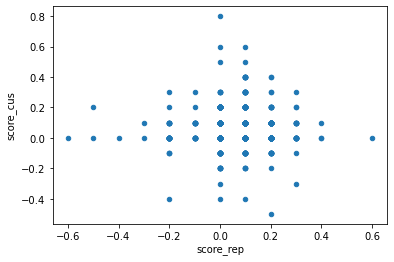

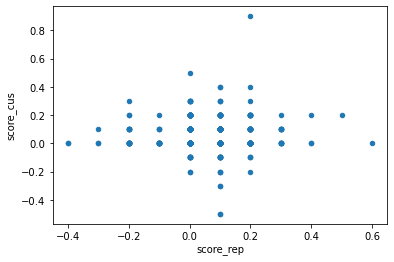

In [71]:
full_df.groupby(cost_vars).plot.scatter('score_rep', 'score_cus')

# 7/26/2022 — Redo sentiment

In [12]:
# huggingface:
# 1. tensorflow: https://developer.apple.com/metal/tensorflow-plugin/
# 2. torch: conda install pytorch torchvision torchaudio -c pytorch
# 3. transformers: conda install -c huggingface transformers
from transformers import pipeline

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

In [42]:
results_cus = sentiment_pipeline(full_df['transcript_cus'][:10].tolist())
results_rep = sentiment_pipeline(full_df['transcript_rep'][:10].tolist())

In [43]:
results_rep

[{'label': 'POSITIVE', 'score': 0.6773339509963989},
 {'label': 'NEGATIVE', 'score': 0.9667125940322876},
 {'label': 'NEGATIVE', 'score': 0.9987851977348328},
 {'label': 'POSITIVE', 'score': 0.9982130527496338},
 {'label': 'NEGATIVE', 'score': 0.9990536570549011},
 {'label': 'POSITIVE', 'score': 0.9996293783187866},
 {'label': 'NEGATIVE', 'score': 0.9938369393348694},
 {'label': 'POSITIVE', 'score': 0.7951898574829102},
 {'label': 'NEGATIVE', 'score': 0.9958199262619019},
 {'label': 'NEGATIVE', 'score': 0.9903406500816345}]

In [44]:
results_cus

[{'label': 'POSITIVE', 'score': 0.6182929277420044},
 {'label': 'NEGATIVE', 'score': 0.9991592168807983},
 {'label': 'NEGATIVE', 'score': 0.9994611144065857},
 {'label': 'POSITIVE', 'score': 0.9979739785194397},
 {'label': 'NEGATIVE', 'score': 0.9993785619735718},
 {'label': 'POSITIVE', 'score': 0.9861232042312622},
 {'label': 'NEGATIVE', 'score': 0.9876309037208557},
 {'label': 'NEGATIVE', 'score': 0.99339359998703},
 {'label': 'NEGATIVE', 'score': 0.9988645315170288},
 {'label': 'NEGATIVE', 'score': 0.9965019226074219}]

In [39]:
# !pip install --upgrade gensim spacy nltk

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gensim
import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')

'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    import re
    import nltk
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

251

In [116]:
full_df.columns

Index(['call_len_sec', 'CREATED_DATE_TIME', 'IVR_REASON', 'INCONTACT_SKILL',
       'PRODUCT_NAME', 'CASE_TIER_1_GLOBAL', 'CASE_TIER_2_US',
       'CASE_TIER_3_US', 'SUBJECT', 'transcript', 'md_desc', 'Length of call',
       'Call type', 'magnitude_rep', 'score_rep', 'transcript_rep',
       'magnitude_cus', 'score_cus', 'transcript_cus', 'cus_sent_type',
       'rep_sent_type'],
      dtype='object')

In [108]:
n_gram = 2
corpus = full_df['SUBJECT'][~full_df['SUBJECT'].isna()].apply(utils_preprocess_text)
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + n_gram]) for i in range(0, 
                     len(lst_words), n_gram)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA

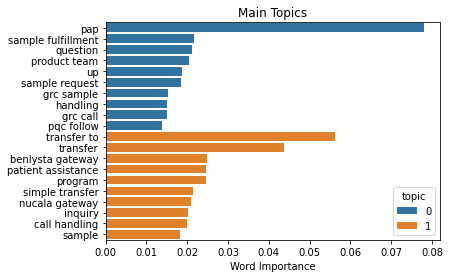

In [112]:
num_topics = 2
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=num_topics, 
                                            random_state=123, update_every=1, chunksize=100, passes=10, 
                                            alpha='auto', per_word_topics=True)   
## output
lst_dics = []
for i in range(0,num_topics):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()